In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt

rng = np.random.RandomState(123)



In [73]:
%matplotlib inline

In [101]:
import pandas as pd

# Read the Excel file
test_point_locations = pd.read_excel('Shot_training_record.xlsx')

# Display the dataframe
print(test_point_locations)

# Read the Excel file and get the second tab
test_data = pd.read_excel('Shot_training_record.xlsx', sheet_name=1)

# Display the dataframe
print(test_data)



   Point  radial    x    y  radii check hole height giant's eye  Unnamed: 6  \
0      1     259 -136  215   254.403223                    13cm         NaN   
1      2     258    0  258   258.000000                    13cm         NaN   
2      3     260  142  215   257.660630                    13cm         NaN   
3      4     340  105  320   336.786282                    13cm         NaN   
4      5     340    0  340   340.000000                    13cm         NaN   
5      6     340  -98  321   335.626280                    13cm         NaN   
6      7     460   69  451   456.247740                    13cm         NaN   

   Unnamed: 7  note thickness (cm)  
0         NaN                 5.25  
1         NaN                  NaN  
2         NaN                  NaN  
3         NaN                  NaN  
4         NaN                  NaN  
5         NaN                  NaN  
6         NaN                  NaN  
    shot number  point  arm angle  x off center of hole  z off hole edg

# Learn To Shoot

Target on the wall above april tags.

projectile is an approximatly 12in diameter donut.

Robot on feild, with angeled arm, at end of arm are in-line flaps

Robot has limelight vision above the front bumper. it can identify april tags and report the ???

In [44]:
pt.arctan(-1/1).eval()/np.pi*180

-45.00000125223908

In [95]:
coords= {'samples': np.arange(100), 
         'position': rng.choice(np.arange(7), 100, replace=True),
         }

with pm.Model(coords=coords) as generate:
    # Priors
    h_miss_sigma = pm.HalfNormal('h_miss_sigma', sigma=5)
    x_miss_sigma = pm.HalfNormal('x_miss_sigma', sigma=5)
    betaF = pm.Normal('BetaF', mu=0, sigma=1)  # BetaF is the conv to effective flap angle of the flaps from the center line of the shooter; assuming equal on both sides

    #Constants
    La = pm.MutableData('La', 56)  # length of arm in cm
    g = pm.MutableData('g', 9.81)  # gravity in m/s^2
    Th = pm.MutableData('Th', 199+13/2)  # height of target in cm
    Ah = pm.MutableData('Ah',146)  # height of april tag in meters

    # Data mutable
    h_mis_record = pm.MutableData('h_mis_record', rng.uniform(-100, 100, 100), dims='samples')  # height of miss in cm
    x_miss_record = pm.MutableData('x_miss_record', rng.uniform(-50, 50, 100), dims='samples')  # x distance miss on target
    Ad = pm.MutableData('Ad', rng.uniform(0, 100, 100), dims='samples')
    Vo = pm.Uniform('Vo', lower=4500, upper=6000, dims='samples')
    x = pm.MutableData('x', rng.uniform(-300, 300, 100), dims='samples')  # distance from april tag centerline along driverstation wall
    y = pm.MutableData('y', rng.uniform(0, 100, 100), dims='samples')  # distance from april tag face out from driverstation wall
    alphaA = pm.Normal('alphaA', sigma=np.pi/4, dims='samples')#, transform='circular')
    alphaF = pm.Uniform('alphaF', lower=-np.pi/5, upper=np.pi/5, dims='samples')#, transform='circular')
    alphaR = pm.Uniform('alphaR', lower=-np.pi, upper=np.pi, dims='samples')#, transform='circular') # angle of the robot releative to the y axis

    # use pathagorean theorem to solve for ground distance from april tag
    # d = sqrt(Ad^2 - Ah^2); Ad is straight line hypthosnuse, Ah is height of april tag
    d = pm.math.sqrt(Ah ** 2 - Ad ** 2)
    # trajectory equation solved for time
    # d = Vo * cos(theta) * t
    t = d / (Vo * pm.math.cos(alphaA))
    # trajectory equation solved for height
    # h = Vo * sin(theta) * t - 0.5 * g * t**2
    h = Vo * pm.math.sin(alphaA) * t - 0.5 * g * t ** 2

    # Shooter height using length of arm (La) and angle of arm (alphaA)
    Sh = La * pm.math.sin(alphaA)
    Th_sim = h + Sh
    h_missDist = Th - Th_sim
    #liklihood function for the height miss
    h_miss = pm.Normal('h_miss', mu=h_missDist, sigma=h_miss_sigma, observed=h_mis_record, dims='samples')

    # angular error to lead to horizontal error
    # Talpha is the angle of the target from the center of the shooter
    alphaFprime = betaF * alphaF * (1 - alphaA / np.pi)
    alphaTraj = alphaR + alphaFprime

    # true horizontal angle to the target
    Talpha = pt.arctan(x/y)
    
    # simplify miss distance as horiz arc length using the string length to the target
    x_missDist = (Talpha - alphaTraj) * pm.math.sqrt(h ** 2 + d ** 2)
    #liklihood function for the x miss
    x_miss = pm.Normal('x_miss', mu=x_missDist, sigma=x_miss_sigma, observed=x_miss_record, dims='samples')





In [96]:
idata = pm.sample_prior_predictive(model=generate, samples=1000)

Sampling: [BetaF, Vo, alphaA, alphaF, alphaR, h_miss, h_miss_sigma, x_miss, x_miss_sigma]


In [97]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

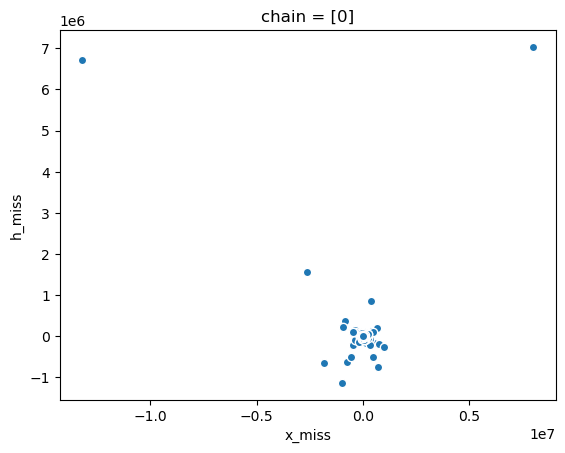

In [98]:
idata.prior_predictive.plot.scatter(x='x_miss', y= 'h_miss')
plt.show()